# `photutils` Extended Sources

`photutils` basically calculates all necessary parameters for extended sources, including ellipticity, rotation angle, etc. 

## 1. Very Basics

In this section, I will demonstrate:

1. Find the threshold value appropriate for source detection by `photutils.detect_thershold`
2. Detect sources with that threshold value using `photutils.detect_sources`
3. Get their properties using `photutils.source_properties`
4. You can play with the result



Let me use the [Leo triplet](https://en.wikipedia.org/wiki/Leo_Triplet) image for this tutorial (preprocessed):

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [ccdproc.ccddata]


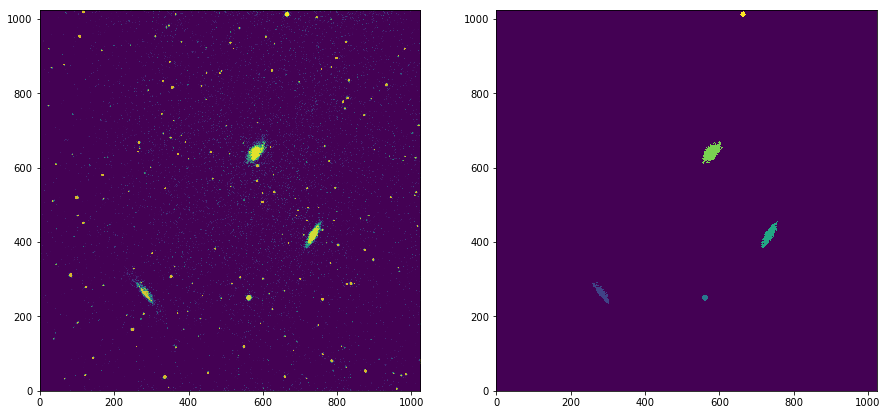

In [21]:
from ccdproc import CCDData
from photutils import detect_threshold, detect_sources, source_properties, properties_table
from matplotlib import pyplot as plt
img = CCDData.read('extented_tutorial/Leo.fits', unit='adu')

thresh = detect_threshold(data=img.data, snr=3)
# This will give you 3*bkg_std.

segm = detect_sources(data=img.data, threshold=thresh, npixels=100, connectivity=8)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(img.data, vmin=220, vmax=400, origin='lower')
ax[0].imshow(segm, alpha=0.2, origin='lower')
ax[1].imshow(segm, origin='lower')
plt.show()


For `detect_sources`, there are two parameters I have to explain: `npixels` and `connectivity`. We want to detect something as "source" only when more than `npixels` nearby pixels have pixel values higher than `threshold`. The latter, `connectivity`, can take either 4 or 8. If you set it to 4, it means you are defining "nearby pixel" as those who share the edges. If 8, "nearby pixel" is defined as pixels which share the edges or corners. SExtractor uses 8 as default, and so does `detect_sources`. 


* **TIP**: As you can see from [`detect_threshold` source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/detection/core.html#detect_threshold), what it gives is the `snr * bkg_std`. That is, if you put `snr = 5`, it gives you 5 times the 3-sigma clipped (infinite iteration) background standard deviation. This is different from what we call "SNR", so be careful. The pixel-wise SNR is given as
$$ S/N = \frac{N - m}{\sqrt{N/g + (R/g)^2 }}$$
where $N$ is the total pixel count, $m$ is the sky count (both in ADU), $R$ is the readout noise in electron, and $g$ is the gain. 

To see the properties table, you can use the following way:


In [18]:
source_props = source_properties(img.data, segm, background=thresh/3)
# The "background" parameter should be inserted as the sky background value.
# All the source properties are calculated after this background subtraction.
proptable = properties_table(source_props)
proptable.pprint(max_width=100)

 id   xcentroid     ycentroid   ...       cxx              cxy              cyy      
         pix           pix      ...     1 / pix2         1 / pix2         1 / pix2   
--- ------------- ------------- ... --------------- ----------------- ---------------
  1 282.468083315  263.41098746 ...  0.034177156699   0.0451542648496 0.0205279567211
  2  561.29223622 250.425957045 ...  0.337176735504 0.000231167533312   0.30883365706
  3 733.759997961  418.61010098 ...  0.034852293785  -0.0355713506276 0.0137206820775
  4  579.50928407 640.450520241 ... 0.0129747016063  -0.0133848236249 0.0106464679467
  5 663.691950578 1011.96858977 ...  0.354294161021   -0.054960572442  0.279878430155


How much information is saved in the `source_props`? All the information and its meaning and discription can be found at [here](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties).

Some important ones are:

* `xcentroid`, `ycentroid`: centroid in image `x` and `y`.
* `bbox`: The box region in `(ymin, xmin, ymax, xmax)` format. Can be used to crop the image to contain only the source you are interested in.
* `data_cutout`: The code, e.g., 
``` python
plt.imshow(source_props[2].data_cutout)
```
will show the `bbox`-cropped region only. The `cutout_centroid` is equivalent position to the `centroid` *on the cutout image*.
* `source_sum`: The pixel sum within the source. 
* `elongation`, `ellipticity`, and `eccentricity`: See the document above for the definitions. 
* `orientation`: The rotation angle of the major axis with respect to the image X axis in counter clockwise.

## 2. Kernel

You may want to detect the sources using Gaussian kernel, which is usual case for SExtractor and DAO starfinding algorithm. What I want to do is following:

1. Since I have image of `FWHM = 3` pixels, let me make a 5 by 5 circular Gaussian kernel
2. Convolve it to the image
3. Detect the source if this convolved pixels have value higher than the threshold
  * The kernel, thus, should be normalized: the attribute `.normalize()` for `astropy.convolution.kernels` objects does this. 
4. In this case, I want to set the `threshold` as a non-constant, but the `background` array from `SExtractor`.


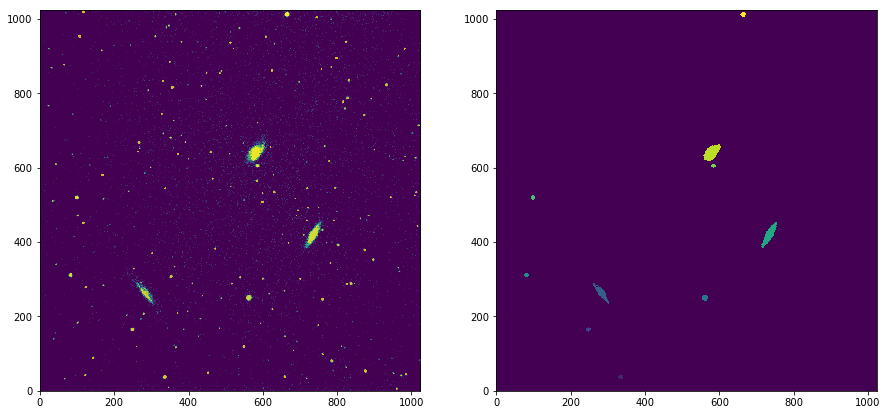

In [25]:
import numpy as np
from photutils import Background2D
from photutils.utils import filter_data
from astropy.convolution import Gaussian2DKernel

bkg = Background2D(img.data, box_size=(32,32), filter_size=(3,3))
# Background estimation with (32x32) mesh, 3x3 median filter.
# By default, SExtractorBackground() is used.

thresh = bkg.background + 3 * bkg.background_rms
# thresh = bkg + 3 * bkg_std

FWHM = 3.
sigma = FWHM / (2*np.sqrt(2*np.log(2))) # FWHM to sigma

# make kernel and normalize
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()

# find sources using convolution
segm = detect_sources(img.data, thresh, npixels=100, filter_kernel=kernel)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(img.data, vmin=220, vmax=400, origin='lower')
ax[0].imshow(segm, alpha=0.2, origin='lower')
ax[1].imshow(segm, origin='lower')
plt.show()

You may wonder how convolution changed the image. You can check it like this, although this may not be necessary all the time:

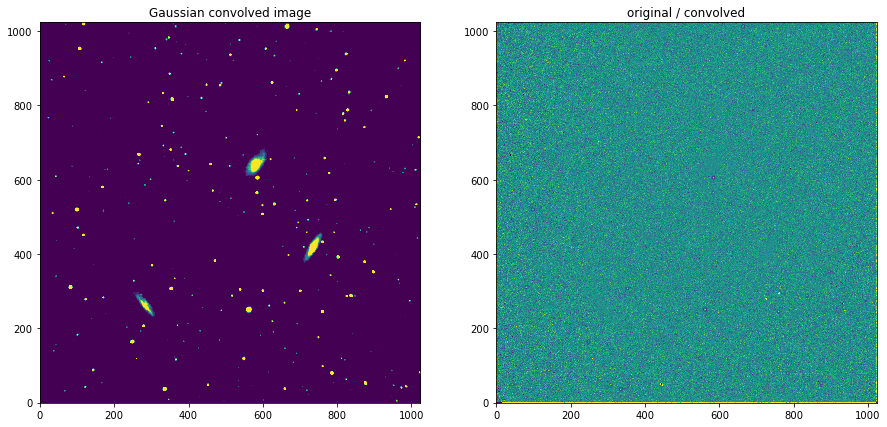

In [28]:
convolved = filter_data(img.data, kernel=kernel)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(convolved, vmin=220, vmax=400, origin='lower')
ax[0].set_title('Gaussian convolved image')
ax[1].imshow(img.data/convolved, origin='lower', vmin=0, vmax=2)
ax[1].set_title('original / convolved')
plt.show()

* **Question**: You may see some strange roundish features in the right image. What are those?


Now that we have segmented image, let's find the source properties and generate the table:

In [29]:
gain = img.header['egain'] # around 2
ronoise = 10               # arbitrary
error = np.sqrt(img.data/gain + (ronoise/gain)**2 + bkg.background_rms**2)
# errormap = sqrt(Poisson + ronoise**2 + bkg_std**2)

source_props = source_properties(img.data, segm, background=bkg.background, error=error)
# The "background" parameter should be inserted as the sky background value.
# All the source properties are calculated after this background subtraction.
proptable = properties_table(source_props)
proptable.pprint(max_width=100)

 id   xcentroid     ycentroid   ...       cxx              cxy              cyy      
         pix           pix      ...     1 / pix2         1 / pix2         1 / pix2   
--- ------------- ------------- ... --------------- ----------------- ---------------
  1  334.55192657 36.8296527303 ...  0.396723194739  -0.0761465142718  0.302538678519
  2 247.604372076 164.136591897 ...  0.393061720854   -0.093970007293  0.356879731636
  3 282.431062448 262.942037956 ... 0.0425291295771   0.0587421843409 0.0272855727363
  4 561.294842358 250.424400412 ...  0.339322321176 -0.00142433892162  0.304966494455
  5 81.3622883971 311.045094095 ...  0.304580239925  -0.0610948838163  0.367392435638
  6 733.953046139 418.855335864 ... 0.0418524684773   -0.042093109272 0.0159243602149
  7 98.1483737612 519.438027637 ...  0.327860740916  -0.0149253109431  0.396925858037
  8   583.9558899 605.044763459 ...  0.461058763812  -0.0212244602681  0.458391252353
  9 579.314873115 640.002053375 ... 0.0159086110178  -

We know the galaxies are those who have the largest area, so I sort the table with respect to `area` and take only the largest three:

In [31]:
proptable.sort('area')
prop_galaxy = proptable[-3:]
prop_galaxy.pprint(max_width=100)

 id   xcentroid     ycentroid   ...       cxx             cxy              cyy      
         pix           pix      ...     1 / pix2        1 / pix2         1 / pix2   
--- ------------- ------------- ... --------------- ---------------- ---------------
  3 282.431062448 262.942037956 ... 0.0425291295771  0.0587421843409 0.0272855727363
  6 733.953046139 418.855335864 ... 0.0418524684773  -0.042093109272 0.0159243602149
  9 579.314873115 640.002053375 ... 0.0159086110178 -0.0165485177818 0.0141999966175


## 3. Sersic Profile

Sujin Lee at SNU suggested me to demonstrate the Sersic profile of an elliptical galaxy for educational purpose, which I think a great suggestion. I will use the [NGC 1132 r-band image data](https://dr12.sdss.org/fields/name?name=ngc1132) from SDSS DR13.

In [35]:
from ccdproc import CCDData
from astropy.convolution import Gaussian2DKernel
from astropy.wcs import WCS
from photutils import detect_sources, source_properties, properties_table

img = CCDData.read('extended_tutorial/ngc1132_r.fits', hdu=0, unit='u.electron/u.s')
# sky has already been subtracted, so essentially 0
sky_std = 0.20
thresh = 3 * sky_std
FWHM = 1.37
# https://dr12.sdss.org/fields/name?name=ngc1132

sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()
wcs = WCS(img.header)  
# If you put WCS to `source_properties`, the centroid RA/DEC will also be calculated.

segm = detect_sources(img.data, 
                      threshold=thresh, 
                      npixels=500,      # Larger npixel to detect only few sources
                      connectivity=8, 
                      filter_kernel=kernel)
source_prop = source_properties(img.data, segm, wcs=wcs)
proptable = properties_table(source_prop)
proptable.sort('ellipticity')

# Choose the one with the largest ellipticity
ngc1132 = proptable[-1] 
print(ngc1132.colnames)
# print out all the parameters calculated from `source_properties`.

INFO: using the unit u.electron/u.s passed to the FITS reader instead of the unit nanomaggy in the FITS file. [ccdproc.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


['id', 'xcentroid', 'ycentroid', 'ra_icrs_centroid', 'dec_icrs_centroid', 'source_sum', 'source_sum_err', 'background_sum', 'background_mean', 'background_at_centroid', 'xmin', 'xmax', 'ymin', 'ymax', 'min_value', 'max_value', 'minval_xpos', 'minval_ypos', 'maxval_xpos', 'maxval_ypos', 'area', 'equivalent_radius', 'perimeter', 'semimajor_axis_sigma', 'semiminor_axis_sigma', 'eccentricity', 'orientation', 'ellipticity', 'elongation', 'covar_sigx2', 'covar_sigxy', 'covar_sigy2', 'cxx', 'cxy', 'cyy']


Check whether the known centroid of NGC 1132 is similar to our centroided value:

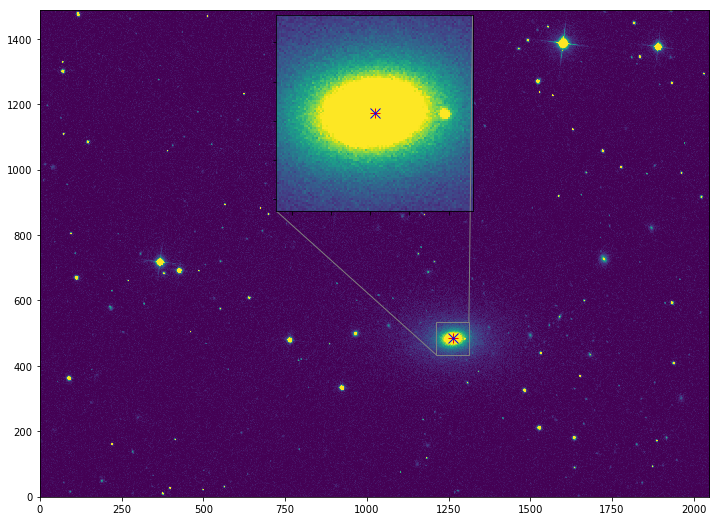

In [38]:
from astropy.coordinates import SkyCoord
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

ra_sdss, de_sdss = 43.2159167, -1.2747222
radec_sdss = SkyCoord(ra_sdss, de_sdss, unit="deg")
x_sdss, y_sdss = radec_sdss.to_pixel(wcs)
x_cent, y_cent = (ngc1132['xcentroid'], ngc1132['ycentroid'])


#Plot
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.imshow(img.data, vmin=0, vmax=1, origin='lower')
ax.plot(x_sdss, y_sdss, marker='+', ms=10, color='r')
ax.plot(x_cent, y_cent, marker='x', ms=10, color='b')

# Make zoom-in
ax2 = zoomed_inset_axes(ax, 6, loc=9) # zoom-factor: 2.5, location: upper-left
ax2.imshow(img.data, vmin=0, vmax=1, origin='lower')
ax2.plot(x_sdss, y_sdss, marker='+', ms=10, color='r')
ax2.plot(x_cent, y_cent, marker='x', ms=10, color='b')
halfcb = 50
ax2.set_xlim(x_cent-halfcb, x_cent+halfcb) # apply the x-limits
ax2.set_ylim(y_cent-halfcb, y_cent+halfcb) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)
mark_inset(ax, ax2, loc1=3, loc2=1, fc="none", ec="0.5")

plt.show()

As you can see, the centroid is almost identical to the catalogued one.

Now, to fit the Sersic profile, first I will get the radial intensity profile of this target. To do so, I will make elliptical annuli with the inner semi-minor axis `b_in = 1, 2, ..., 100`, outer semi-minor axis `b_out = 2, 3, ..., 101`. The semi-major axis values are calculated by multiplying the elongation ($ e = a/b > 1$), such as `a_in = b_in * e`. 

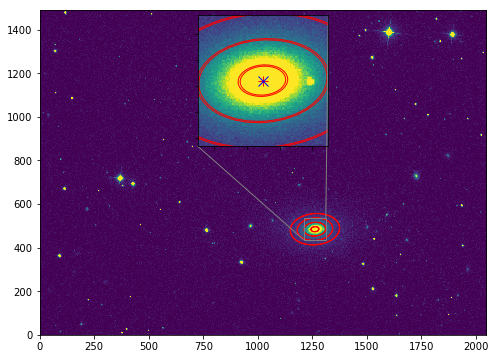

In [45]:
from photutils import EllipticalAnnulus as EllAn
from photutils import aperture_photometry as APPHOT
e = ngc1132['elongation'] # := a/b
theta = ngc1132['orientation']
nap = 100
annul = [EllAn(positions=(x_cent, y_cent), a_in=b0*e, a_out=(b0+1)*e, 
               b_out=(b0+1), theta=theta) for b0 in range(1, nap+1)]
phot = APPHOT(img.data, annul)

#Plot
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.imshow(img.data, vmin=0, vmax=1, origin='lower')
[annul[i].plot(ax=ax, color='red') for i in (10, 30, 50, 70)]
# Make zoom-in
ax2 = zoomed_inset_axes(ax, 6, loc=9) # zoom-factor: 2.5, location: upper-left
ax2.imshow(img.data, vmin=0, vmax=1, origin='lower')
ax2.plot(x_sdss, y_sdss, marker='+', ms=10, color='r')
ax2.plot(x_cent, y_cent, marker='x', ms=10, color='b')
halfcb = 50
ax2.set_xlim(x_cent-halfcb, x_cent+halfcb) # apply the x-limits
ax2.set_ylim(y_cent-halfcb, y_cent+halfcb) # apply the y-limits
[annul[i].plot(ax=ax2, color='red') for i in (10, 30, 50, 70)]
plt.yticks(visible=False)
plt.xticks(visible=False)
mark_inset(ax, ax2, loc1=3, loc2=1, fc="none", ec="0.5")

plt.show()


The next step is to draw the obtained intensity profile. This can be done by plotting the "annulus sum" divided by "annulus area" with respect to the semi-major axis length:

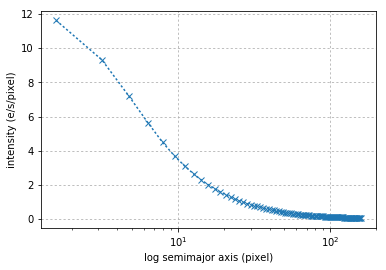

In [52]:
semimaj = np.arange(1, nap+1)*e
counts = np.zeros(nap)
dcounts = np.zeros(nap)
B_surf = []
for i in range(0, nap):
    count = phot[phot.colnames[i+3]]
    counts[i] = count
    # phot.colnames = column names = "aperture_sum_X"
    dcount = count / annul[i].area() # count per pixel
    dcounts[i] = dcount
    bright = np.log10(dcount)
    B_surf.append(bright)

plt.plot(semimaj, dcounts, ls=':', marker='x')
plt.xscale('log')
plt.ylabel('intensity (e/s/pixel)')
plt.xlabel('log semimajor axis (pixel)')
plt.grid(ls=":")
plt.show()

Finally, the fitting can be done by Levenberg-Marquadt least square fitter provided by `astropy`. The `r_eff` should be given quite large as the initial value, since the local minimum may be found at strange place if tou set, e.g., `r_eff=1`. (Check by yourself).

Model: Sersic1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        r_eff           n      
    -------------- ------------- -------------
    0.669602220786 34.7646612632 2.00301751139


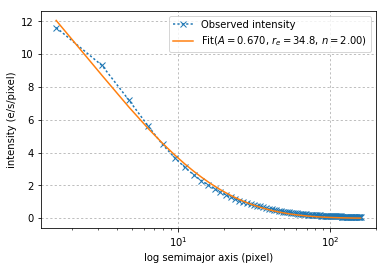

In [60]:
from astropy.modeling.functional_models import Sersic1D
from astropy.modeling.fitting import LevMarLSQFitter

f_init = Sersic1D(amplitude=ngc1132['max_value'], r_eff=10, n=4.)
fitter = LevMarLSQFitter()
fitted = fitter(f_init, semimaj, dcounts)
print(fitted)

plt.plot(semimaj, dcounts, ls=':', marker='x', label='Observed intensity')
plt.plot(semimaj, fitted(semimaj), ls='-', 
         label='Fit($A={:.3f}$, $r_e={:.1f}$, $n={:.2f}$)'.format(fitted.amplitude.value,
                                                   fitted.r_eff.value,
                                                   fitted.n.value))
plt.xscale('log')
plt.grid(ls=':')
plt.ylabel('intensity (e/s/pixel)')
plt.xlabel('log semimajor axis (pixel)')
plt.legend()
plt.show()

In this plot, I did not take the error into account. In your real work, you MUST take the error sources 